TODO: 

add some plotting

add way to determine clustering linkage distances

clean up later modules

put cluster selection into module

make cluster selection work with sparse inputs

chase down memory usage in cluster selection

# Setup

In [93]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: rich_clust
python version: 3.9.12


In [2]:
import os
from pathlib import Path
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt
import numpy as np
import sklearn.manifold
import sklearn.cluster
import seaborn as sns
import pandas as pd
import sparse
import cv2
import natsort

import torch
from kymatio.torch import Scattering2D

import gc
from tqdm.notebook import tqdm
import copy
import time
import random
import functools
import multiprocessing as mp


In [3]:
params = {
    'dir_github': r'/media/rich/Home_Linux_partition/github_repos/',
    'dir_allOuterFolders': r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10",
    'pathSuffixToStat': 'plane1/stat.npy',
    'pathSuffixToOps': 'plane1/ops.npy',
    'pref_use_NN_distances': True,
    'use_GPU': True,
    'pref_blurROIs': True,
    'params_blur': {
        'kernel_size': 7, # Edge length of kernel image. Make odd number.
        'kernel_width': 2.1, # width of 1 full cosine cycle for the 2d cosine kernel. Use width=2 for a single pixel.
    },
    'mask_power': 1, ## This parameter determines how 'binary'-looking masks are. Small values = more binary. Large values weight bright pixels more. mask_scaled = mask**mask_power
    'params_dIOU': {
        'algorithm': 'brute', ## Can be 'brute', 'auto', or anything from sklearn.neighbors.NearestNeighbors
        'n_neighbors': 'full', ## Can either be an int or 'full', in which case the output will not be sparse
    }
}

In [4]:
dir_github = Path(params['dir_github']).resolve()

import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import path_helpers, torch_helpers, featurization, indexing, misc, torch_helpers, plotting_helpers, classification, math_functions, parallel_helpers, clustering, image_processing, pickle_helpers, container_helpers

In [5]:
device = torch_helpers.set_device(use_GPU=params['use_GPU'])

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)


In [6]:
%load_ext autoreload
%autoreload 2
from registration_rClust import data_importing, visualization, alignment, blurring, helpers, ROInet, scatteringWaveletTransformer, similarity_graph, cluster_assignment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%matplotlib notebook

# Import paths

In [8]:
def print_list(l):
    for item in l:
        print(item)

In [9]:
dir_allOuterFolders = Path(params['dir_allOuterFolders']).resolve()

folders_allSessions = natsort.natsorted(path_helpers.get_dir_contents(dir_allOuterFolders)[0])

folders_toUse = folders_allSessions
# folders_toUse = list(map(folders_allSessions.__getitem__, [np.arange(1,9, dtype=np.int32)]))


# dir_allS2pFolders = [dir_allOuterFolders / folder / 'exp' / 'suite2p' / 'plane0' for folder in folders_toUse]
dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_toUse]

pathSuffixToStat = params['pathSuffixToStat']
pathSuffixToOps = params['pathSuffixToOps']

paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:2]
paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:2]

print(folders_allSessions)
print(folders_toUse)
print_list(dir_allS2pFolders)
print_list(paths_allStat)

['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']
['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D1
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D2
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D3
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D4
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D5
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D6
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D7
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Vale

# Import data

In [10]:
data = data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    verbose=True,
)

In [11]:
data.import_statFiles();

data.import_ROI_centeredImages(
    out_height_width=[36, 36],
    max_footprint_width=1025,
);

data.import_FOV_images(
    type_meanImg='meanImgE',
    images=None
);

data.import_ROI_spatialFootprints(workers=-1);

Imported 2 stat files into class as self.statFiles. Total number of ROIs: 5249. Number of ROI from each file: [2451, 2798]


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.85it/s]

Converted 2 spatial footprint files into small centered images in self.ROI_images.


Imported 2 FOV images into class as self.FOV_images
Imported 2 sessions of spatial footprints into sparse arrays.


In [12]:
# visualization.display_toggle_image_stack(data.FOV_images)

# Alignment

In [13]:
aligner = alignment.Alinger(
    method='createOptFlow_DeepFlow',
    kwargs_method=None
)

aligner.register_ROIs(
    templateFOV=data.FOV_images[0],
    FOVs=data.FOV_images,
    ROIs=data.spatialFootprints,
    return_sparse=True,
    normalize=True,
);

100%|█████████████████████████████████████████████| 2/2 [00:25<00:00, 12.94s/it]


In [14]:
# visualization.display_toggle_image_stack(aligner.FOVs_aligned)
# visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())

## Blur ROIs (optional)

In [15]:
blurrer = blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),
    kernel_halfWidth=2.0,
    device='cpu',
    plot_kernel=False
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned,
    batch_size=2000,
);

In [16]:
# visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

## Neural network embedding distances

In [17]:
data.ROI_images[0].shape

(2451, 36, 36)

In [18]:
hash_dict_true = {
    'params': ('params.json', '877e17df8fa511a03bc99cd507a54403'),
    'model': ('model.py', '6ef5c29793ae16a64e43e8cab33d9ff4'),
    'state_dict': ('ConvNext_tiny__1_0_unfrozen__simCLR.pth', 'a5fae4c9ea95f2c78b4690222b2928a5'),
}

roinet = ROInet.ROInet_embedder(
    device='cuda:0',
    dir_networkFiles='/home/rich/Downloads/ROInet',
    download_from_gDrive='check_local_first',
    gDriveID='1FCcPZUuOR7xG-hdO6Ei6mx8YnKysVsa8',
    hash_dict_networkFiles=hash_dict_true,
    verbose=True,
)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    goal_size=250,
    ptile_norm=90,
    scale_norm=0.6,
    pref_plot=False,
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    
)

roinet.generate_latents();

Successful hash comparison. Found matching files: {'params': '/home/rich/Downloads/ROInet/params.json', 'model': '/home/rich/Downloads/ROInet/model.py', 'state_dict': '/home/rich/Downloads/ROInet/ConvNext_tiny__1_0_unfrozen__simCLR.pth'}
Imported model from /home/rich/Downloads/ROInet/model.py
Loaded params_model from /home/rich/Downloads/ROInet/params.json


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /home/rich/Downloads/ROInet/ConvNext_tiny__1_0_unfrozen__simCLR.pth
Loaded network onto device cuda:0
Starting: resizing ROIs


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader
starting: running data through network


  0%|                                                   | 0/657 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node 

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile informati

completed: running data through network


In [19]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

## Scattering wavelet embedding distances

In [20]:
swt = scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 8}, 
    image_shape=(36,36), 
    device='cuda:0'
)

swt.transform(ROI_images=np.concatenate(data.ROI_images, axis=0));

## Compute similarities

In [21]:
sim = similarity_graph.ROI_graph(
    device='cpu',
    n_workers=-1,
    spatialFootprint_maskPower=0.8,
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
    block_height=50,
    block_width=50,
    overlapping_width_Multiplier=0.1,
#     outer_block_height=75,
#     outer_block_width=75,
    algorithm_nearestNeigbors_spatialFootprints='brute',
    n_neighbors_nearestNeighbors_spatialFootprints='full',
    locality=1,
)

Outer block height not specified. Using 50.0
Outer block width not specified. Using 50.0


<IPython.core.display.Javascript object>


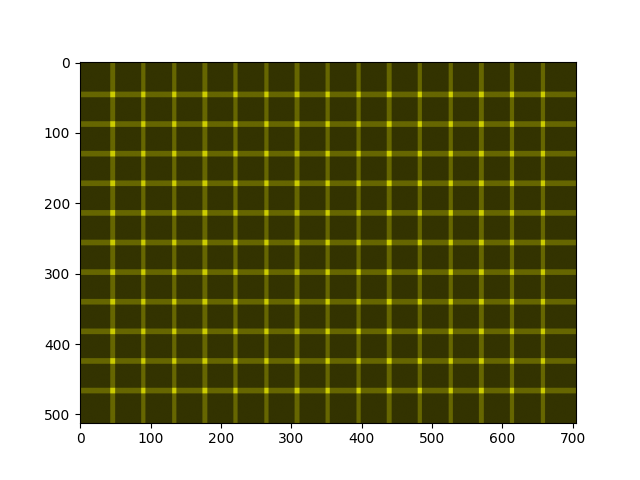

In [22]:
sim.visualize_blocks()

In [87]:
sim._compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    ROI_session_bool=data.sessionID_concat,
    linkage_methods=['single', 'complete', 'ward', 'average'],
    linkage_distances=math_functions.bounded_logspace(0.05, 2, 50),
    min_cluster_size=2,
    max_cluster_size=None,
    batch_size_hashing=100,
);

100%|█████████████████████████████████████████| 192/192 [02:02<00:00,  1.57it/s]


In [94]:
sim._compute_cluster_similarity_graph(
        cluster_similarity_reduction_intra='mean',
        cluster_similarity_reduction_inter='max',
        cluster_silhouette_reduction_intra='mean',
        cluster_silhouette_reduction_inter='max',
        n_workers=100,
);

Starting: Making cluster spatial footprints
Completed: Making cluster spatial footprints
Starting: Computing cluster similarities


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/sparse/_umath.py:541: RuntimeWarning: invalid value encountered in true_divide
  fill_value_array = self.func(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/sparse/_umath.py:647: RuntimeWarning: divide by zero encountered in true_divide
  func_data = self.func(*func_args, dtype=self.dtype, **self.kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/sparse/_umath.py:541: RuntimeWarning: invalid value encountered in true_divide
  fill_value_array = self.func(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/sparse/_umath.py:541: RuntimeWarning: invalid value encountered in true_divide
  fill_value_array = self.func(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/sparse/_

Completed: Computing cluster similarities
Starting: Computing modified cluster silhouettes


100%|██████████████████████████████████████| 2246/2246 [00:03<00:00, 567.91it/s]

Completed: Computing modified cluster silhouettes


In [95]:
w_raw = torch.as_tensor((np.array(sim.cluster_bool.sum(1)).squeeze()**2) * (10**(sim.c_sil*1.5)))

<IPython.core.display.Javascript object>


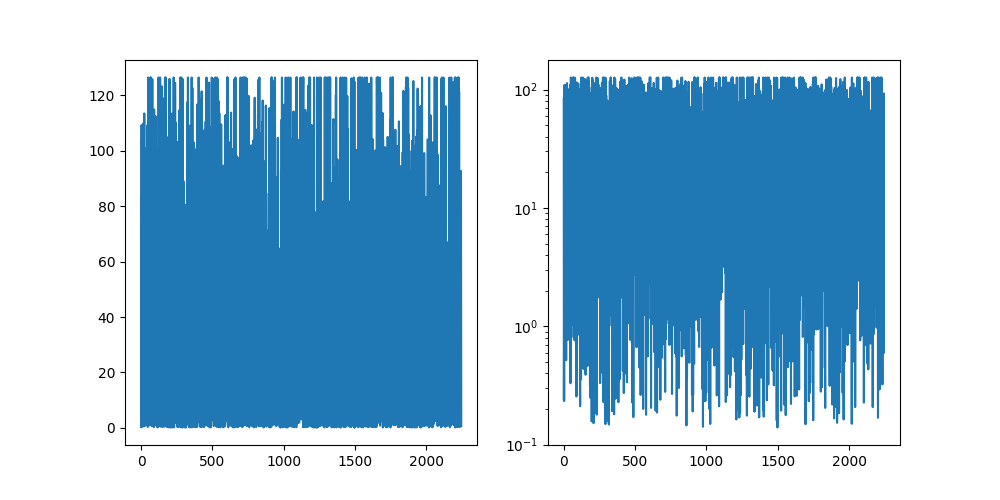

In [96]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(w_raw.cpu())
# plt.ylim([0,1.1])
axs[1].plot(w_raw.cpu())
axs[1].set_yscale('log')

<IPython.core.display.Javascript object>


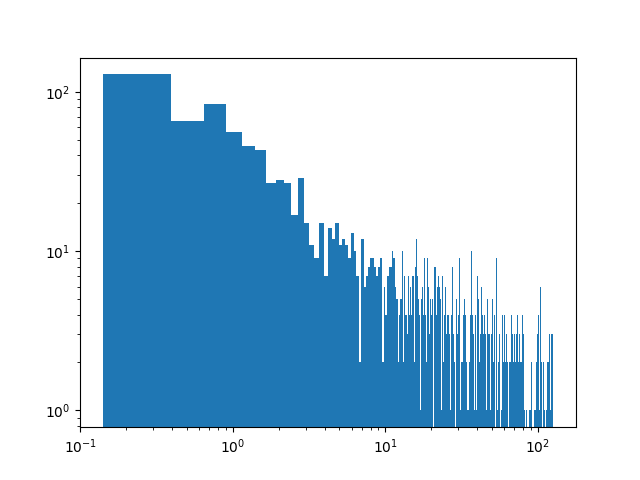

In [97]:
plt.figure()
plt.hist(w_raw.cpu(), 500)
# plt.ylim([0,1.1])
# axs[1].hist(w_raw.cpu())
plt.yscale('log')
plt.xscale('log')

<IPython.core.display.Javascript object>


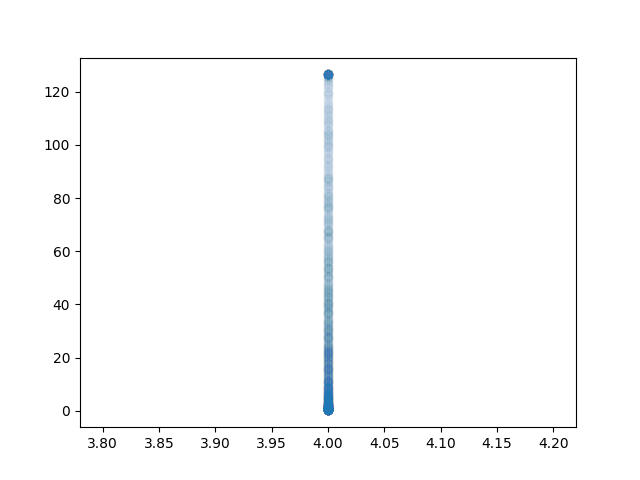

In [98]:
plt.figure()
plt.scatter((np.array(sim.cluster_bool.sum(1)).squeeze()**2), w_raw, alpha=0.01)

In [99]:
idx_c_good = (w_raw>1e-6)
# idx_c_good = sim.cluster_bool.sum(1) > 12
idx_c_good = np.where(idx_c_good)[0]

len(idx_c_good) / sim.cluster_bool.shape[0]

1.0

In [100]:
DEVICE = 'cuda:0'

# c = (c_max*1 + c_mean*1)/2 + c_redundant*0
# c = copy.copy(sim.c_sim)[idx_c_good][:,idx_c_good]
c = torch.as_tensor(sim.c_sim.toarray())[idx_c_good][:, idx_c_good]

# c = c_max + c_redundant*1
# c = c_local*1
# c = c_sum
# c = c_mean
# c = c_local
# c = c_sum + c_redundant*2

In [101]:
# h = copy.copy(sim.cluster_bool)[:, idx_c_good]
h = torch.as_tensor(sim.cluster_bool.toarray())[idx_c_good].T

In [102]:
w = w_raw[idx_c_good]
w = w / w.max()
# w = torch.ones((len(idx_c_good)))

In [103]:
c_coo = indexing.scipy_sparse_to_torch_coo(sim.c_sim).coalesce()

In [104]:
crc = cluster_assignment.Cluster_Assigner(
    c=c_coo,
    h=h,
    w=w,
    device=DEVICE,
    m_init=(torch.ones(c.shape[0])*-5 + torch.rand(c.shape[0])*1).type(torch.float32),
    optimizer_partial=functools.partial(torch.optim.Adam, lr=1e-1, betas=(0.9, 0.900)),
    scheduler_partial=functools.partial(torch.optim.lr_scheduler.CyclicLR, base_lr=1e-3, max_lr=3e0, step_size_up=250, cycle_momentum=False, verbose=False),
    dmCEL_temp=1,
    dmCEL_sigSlope=2,
    dmCEL_sigCenter=0.5,
    dmCEL_penalty=1e0,
    sampleWeight_softplusKwargs={'beta': 500, 'threshold': 50},
    sampleWeight_penalty=1e2,
    fracWeighted_goalFrac=1.0,
    fracWeighted_sigSlope=2,
    fracWeighted_sigCenter=0.5,
    fracWeight_penalty=1e2,
    maskL1_penalty=2e-5,
    tol_convergence=1e-9,
    window_convergence=50,
    freqCheck_convergence=50,
    verbose=True,
)

In [105]:
crc.fit(
    min_iter=1e3,
    max_iter=2e3,
    verbose=True, 
    verbose_interval=10
)

iter: 0:  loss_total: 53.9209  lr: 0.01300   loss_cs: 0.4770  loss_fracWeighted: 53.4439  loss_sampleWeight: 0.0000  loss_maskL1: 0.0000  diff_loss: nan  loss_smooth: nan
iter: 10:  loss_total: 53.6239  lr: 0.13296   loss_cs: 0.1803  loss_fracWeighted: 53.4436  loss_sampleWeight: 0.0000  loss_maskL1: 0.0000  diff_loss: nan  loss_smooth: nan
iter: 20:  loss_total: 53.4338  lr: 0.25292   loss_cs: 0.0114  loss_fracWeighted: 53.4224  loss_sampleWeight: 0.0000  loss_maskL1: 0.0000  diff_loss: nan  loss_smooth: nan
iter: 30:  loss_total: 51.8559  lr: 0.37288   loss_cs: 0.0025  loss_fracWeighted: 51.8508  loss_sampleWeight: 0.0000  loss_maskL1: 0.0026  diff_loss: nan  loss_smooth: nan
iter: 40:  loss_total: 47.7103  lr: 0.49284   loss_cs: 0.0265  loss_fracWeighted: 47.6745  loss_sampleWeight: 0.0001  loss_maskL1: 0.0092  diff_loss: nan  loss_smooth: nan
iter: 50:  loss_total: 47.6342  lr: 0.61280   loss_cs: 0.0212  loss_fracWeighted: 47.6029  loss_sampleWeight: 0.0006  loss_maskL1: 0.0096  di

iter: 500:  loss_total: 47.1666  lr: 0.01300   loss_cs: 0.1245  loss_fracWeighted: 47.0281  loss_sampleWeight: 0.0009  loss_maskL1: 0.0132  diff_loss: nan  loss_smooth: nan
iter: 510:  loss_total: 47.1666  lr: 0.13296   loss_cs: 0.1245  loss_fracWeighted: 47.0281  loss_sampleWeight: 0.0009  loss_maskL1: 0.0132  diff_loss: nan  loss_smooth: nan
iter: 520:  loss_total: 47.1666  lr: 0.25292   loss_cs: 0.1245  loss_fracWeighted: 47.0280  loss_sampleWeight: 0.0009  loss_maskL1: 0.0132  diff_loss: nan  loss_smooth: nan
iter: 530:  loss_total: 47.1666  lr: 0.37288   loss_cs: 0.1244  loss_fracWeighted: 47.0281  loss_sampleWeight: 0.0009  loss_maskL1: 0.0132  diff_loss: nan  loss_smooth: nan
iter: 540:  loss_total: 47.1665  lr: 0.49284   loss_cs: 0.1244  loss_fracWeighted: 47.0280  loss_sampleWeight: 0.0009  loss_maskL1: 0.0132  diff_loss: nan  loss_smooth: nan
iter: 550:  loss_total: 47.1620  lr: 0.61280   loss_cs: 0.1247  loss_fracWeighted: 47.0232  loss_sampleWeight: 0.0009  loss_maskL1: 0.0

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


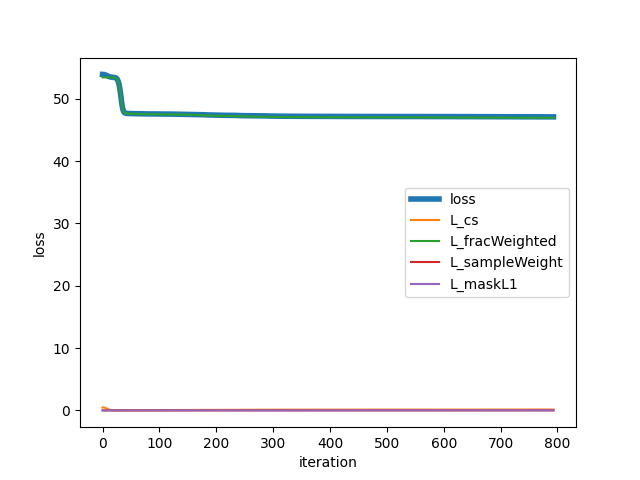

In [106]:
crc.plot_loss()

In [300]:
gc.collect()

torch.cuda.empty_cache()

gc.collect()

torch.cuda.empty_cache()

<IPython.core.display.Javascript object>


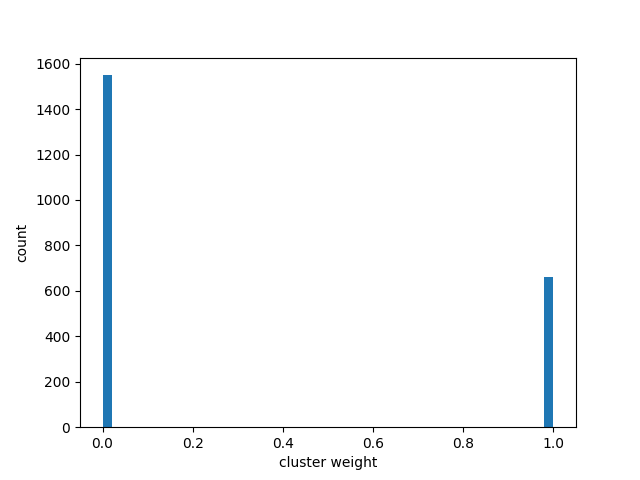

In [107]:
crc.plot_clusterWeights()

<IPython.core.display.Javascript object>


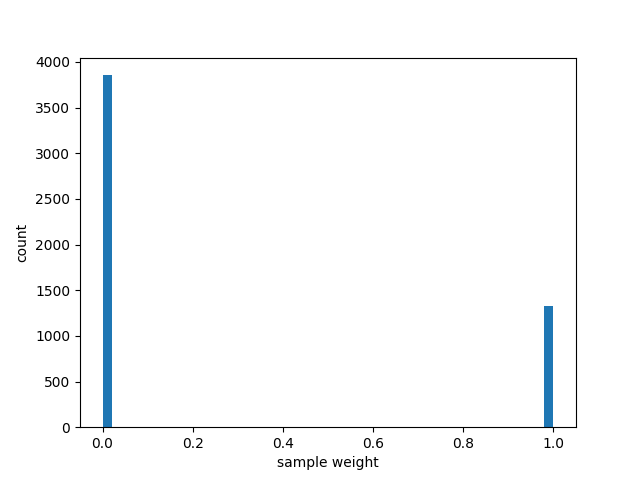

In [108]:
crc.plot_sampleWeights()

[5249, 693]


<IPython.core.display.Javascript object>


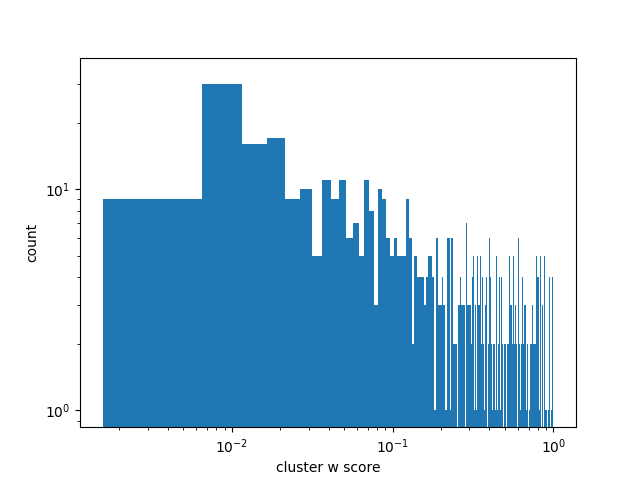

In [109]:
crc.plot_clusterScores(bins=200)
plt.xscale('log')
plt.yscale('log')

In [110]:
m_threshold=0.9

preds, confidence, scores_samples, m_bool = crc.predict(m_threshold=m_threshold)

[5249, 663]


In [111]:
m_bool.sum()

tensor(663)

<IPython.core.display.Javascript object>


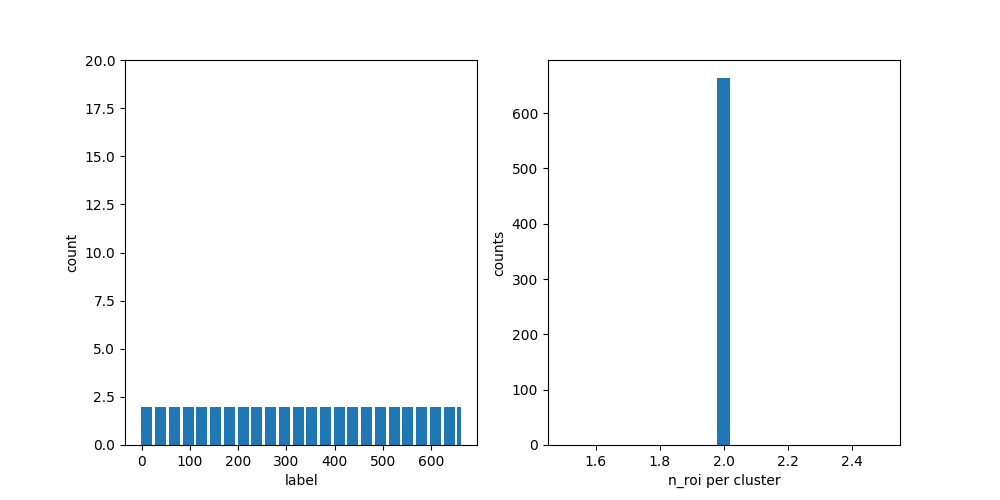

(0.0, 20.0)

In [112]:
fig, axs = crc.plot_labelCounts()
axs[0].set_ylim([0,20])

<IPython.core.display.Javascript object>


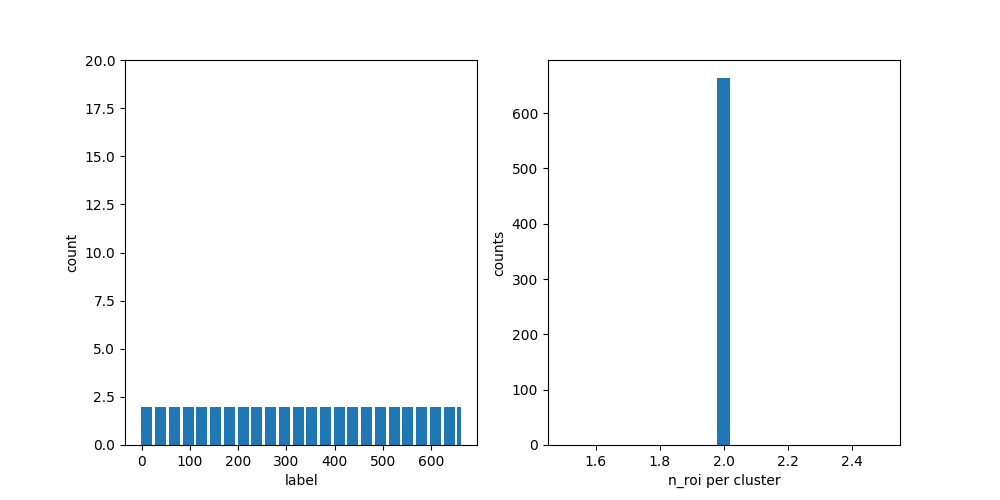

(0.0, 20.0)

In [113]:
fig, axs = crc.plot_labelCounts()
axs[0].set_ylim([0,20])

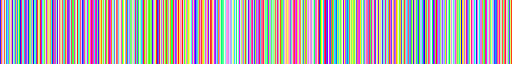

In [114]:
cmap = plotting_helpers.rand_cmap(nlabels=int(preds.max()), under=[0,0,0,0.0], verbose=False);
cmap

<IPython.core.display.Javascript object>


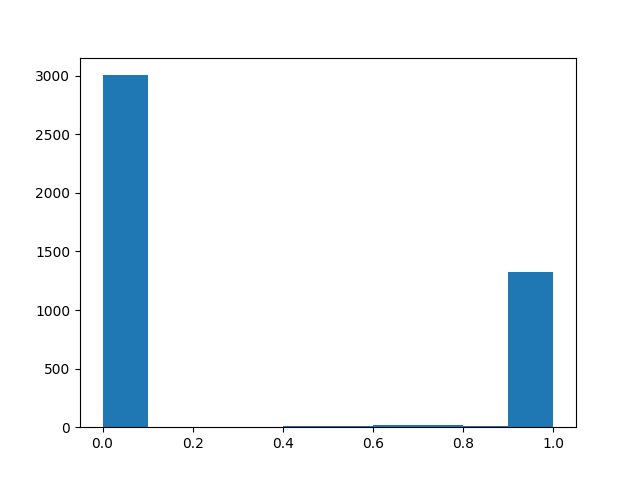

In [115]:
plt.figure()
plt.hist(confidence);

<IPython.core.display.Javascript object>


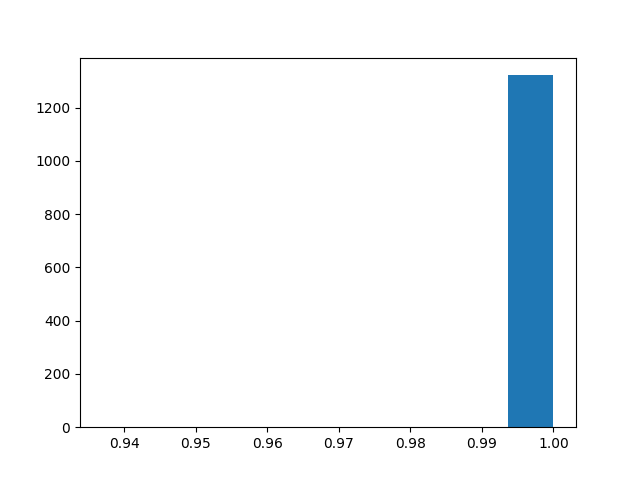

In [116]:
plt.figure()
plt.hist(confidence[preds>=0]);

# Colored clusters image
make an animation loop of an entire FOV looping through each session with all the ROIs. \
Each ROI in a cluster is given a distinct cluster color

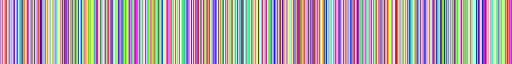

In [117]:
cmap = plotting_helpers.rand_cmap(nlabels=int(preds.max()), under=[0,0,0,0.0], verbose=False);
cmap

In [118]:
idx_roi_cat = np.concatenate([np.arange(sfs.shape[0]) for sfs in aligner.ROIs_aligned]) # indices of each ROI concatenated together
idx_roi_session = np.concatenate([np.ones(sfs.shape[0])*ii for ii,sfs in enumerate(aligner.ROIs_aligned)])

In [119]:
n_planes = data.n_sessions
labels = classification.squeeze_integers(preds.numpy().astype(np.int64))

labels[(confidence < 0.5).numpy()] = -1
# labels = labels

ucid_toUse = labels
idx_roi_session_toUse = idx_roi_session

colors = sparse.COO(plotting_helpers.rand_cmap(len(np.unique(ucid_toUse)), verbose=False)(np.int64(ucid_toUse))[:,:3])
# colors *= (1-((scores_samples / scores_samples.max()).numpy())**7)[:,None]
# colors *= (((1/scores_samples) / (1/scores_samples).max()).numpy()**1)[:,None]

plane_oneHot = classification.idx_to_oneHot(idx_roi_session_toUse.astype(np.int32))

ROIs_csr = scipy.sparse.csr_matrix(scipy.sparse.vstack(aligner.ROIs_aligned))
ROIs_csr_scaled = ROIs_csr.multiply(ROIs_csr.max(1).power(-1))
ROIs_sCOO = sparse.COO(ROIs_csr_scaled)

def tile_sparse(arr, n_tiles):
    """
    tiles along new (last) dimension
    """
    out = sparse.stack([arr for _ in range(n_tiles)], axis=-1)
    return out

ROIs_tiled = tile_sparse(tile_sparse(ROIs_sCOO, n_planes), 3)

ROIs_colored = ROIs_tiled * colors[:,None,None,:] * plane_oneHot[:,None,:,None]

FOV_ROIs_colored = ROIs_colored.sum(0).reshape((data.FOV_height, data.FOV_width, n_planes, 3)).transpose((2,0,1,3))

In [120]:
FOV_all_noClip = copy.copy(FOV_ROIs_colored.todense())
FOV_all_noClip[FOV_all_noClip>1] = 1

<IPython.core.display.Javascript object>


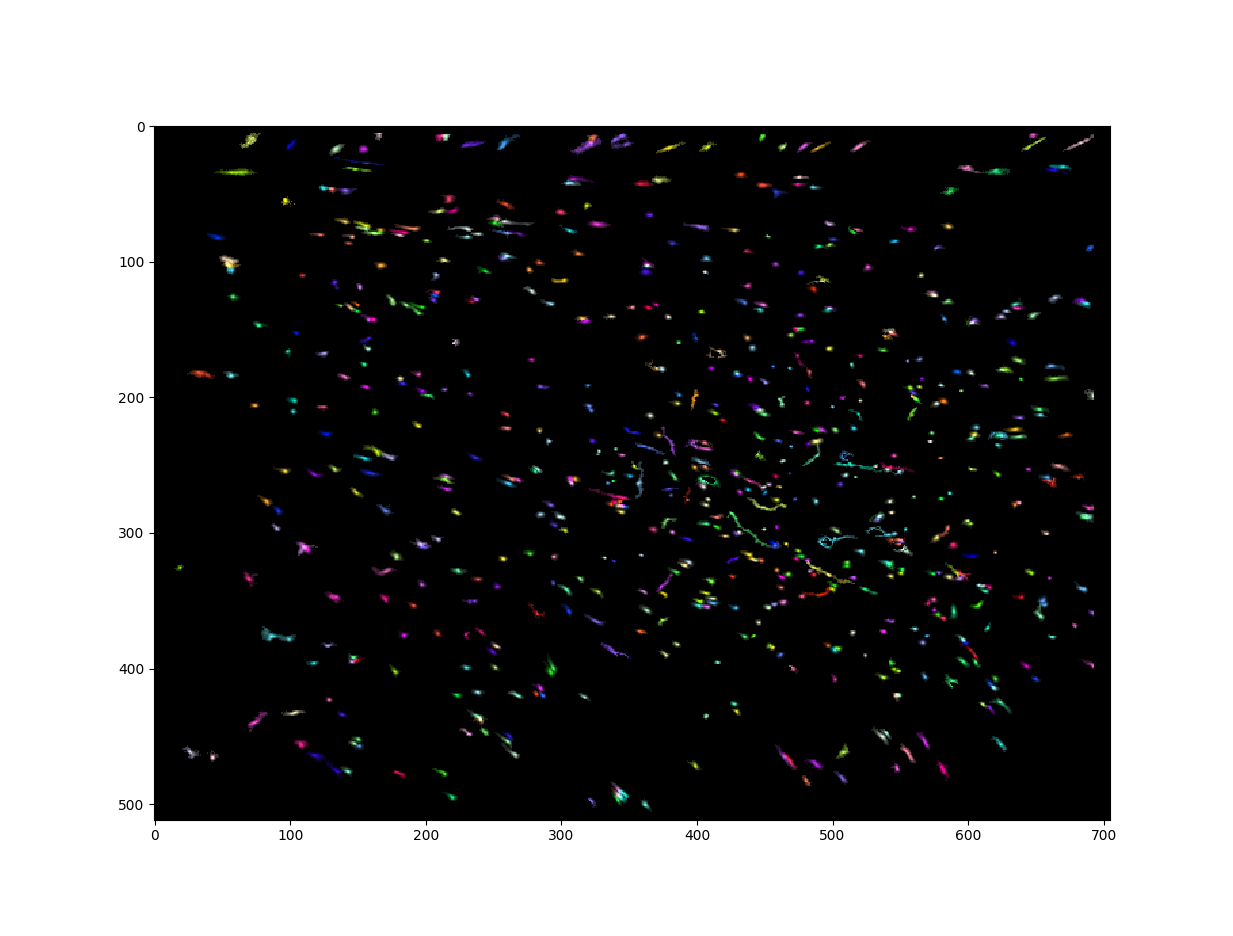

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [121]:
%matplotlib notebook
from ipywidgets import widgets, interact

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
imshow_FOV = ax.imshow(FOV_all_noClip[0], interpolation='none')

def update(i_frame = 0):
    fig.canvas.draw_idle()
    imshow_FOV.set_data(FOV_all_noClip[i_frame])


interact(update, i_frame=widgets.IntSlider(min=0, max=FOV_all_noClip.shape[0]-1, step=1, value=0));

<IPython.core.display.Javascript object>


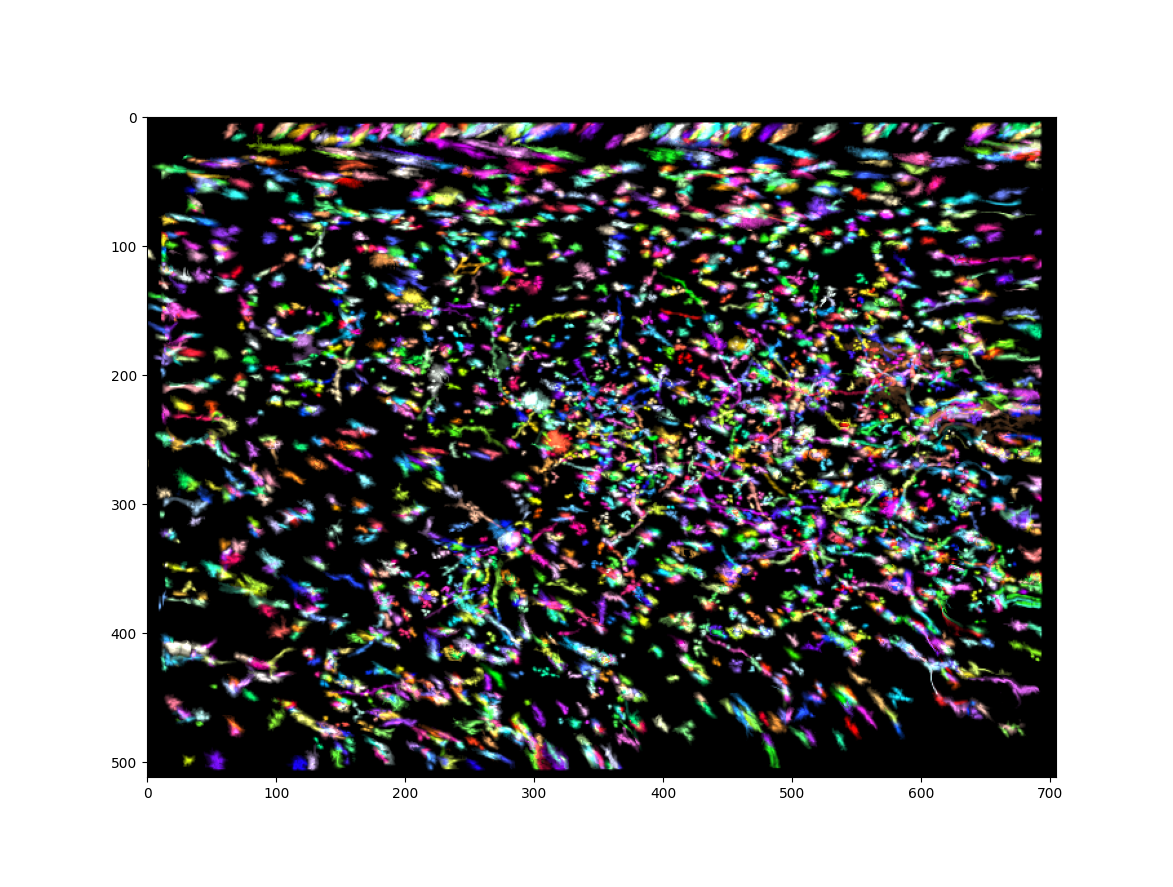

In [363]:
plt.figure()
plt.imshow(FOV_all_noClip.max(0))

# TODO: get mean reduction working
# get silhouette score working
# document
# remove unncessary make blocks stuff


In [192]:
sim.cluster_bool

<43407x37061 sparse matrix of type '<class 'numpy.bool_'>'
	with 194690 stored elements in Compressed Sparse Row format>

In [ ]:
h_raw = torch.stack([torch.as_tensor(indexing.idx2bool(idx.toarray().squeeze(), length=sim.n_roi), dtype=torch.float32) for idx in sim.cluster_idx], dim=0).T.type(torch.bool)

In [36]:
def display_clustering_widget(
    embeddings, 
    min_samples, 
    max_samples=None,
    min_slider=0.01,
    max_slider=5, 
    start_slider=1.0,
    single_color=False,
    ):

    from ipywidgets import interact, widgets
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    sc = ax.scatter(embeddings[:,0], embeddings[:,1], s=10)
    # sc = ax.scatter(embeddings2[:,0], embeddings2[:,1], embeddings2[:,2], s=15)

    def get_val_counts(vals):
        vals_unique = np.unique(vals)
        vals_counts = np.zeros_like(vals, dtype=np.int64)
        for ii, val in enumerate(vals_unique):
            vals_counts[vals==val] = np.sum(vals==val)
        return vals_counts
    def update(t=1):
        t_toUse = t/10000
        
#         # Compute DBSCAN
#         db = sklearn.cluster.DBSCAN(
#             eps=eps_toUse,
#             min_samples=min_samples, 
#     #         metric='manhattan',
#             metric_params=None, 
#             algorithm='auto',
#             leaf_size=30, 
#             p=2, 
#             n_jobs=-1
#         ).fit(embeddings)

#         labels = db.labels_
#     #     labels = db.labels_ - db.labels_.min()
    
        labels = scipy.cluster.hierarchy.fcluster(links['average'], t=t_toUse, criterion='distance')
        
        if max_samples is not None:
            labels[get_val_counts(labels) > max_samples] = -1

        if single_color:
            cmap = rand_cmap(2, verbose=False)
        else:
            cmap = rand_cmap(len(np.unique(labels)), verbose=False)

        if len(np.unique(labels)) == 1:
            print('Eps value gives one big cluster. Adjust')
        else:
            sc.set_color(cmap(squeeze_integers(labels)+1))

            fig.canvas.draw_idle()
            ax.set_title(f'eps={round(t_toUse,3)}, n_clusters={len(np.unique(labels))}')
            print(np.unique(labels))

    interact(update, t=widgets.IntSlider(min=min_slider, max=max_slider, step=1, value=start_slider));
#     interact(update, t=widgets.IntSlider(min=0, max=200, step=1, value=1));
    

rand_cmap = plotting_helpers.rand_cmap
squeeze_integers = classification.squeeze_integers

In [37]:
cmap = plotting_helpers.rand_cmap(nlabels=d.shape[0], verbose=False)

# c_labels = cmap(tuple(torch.linspace(0.,1., len(labels))))

In [67]:
meds = np.concatenate(sf_data.get_midCoords())

<IPython.core.display.Javascript object>


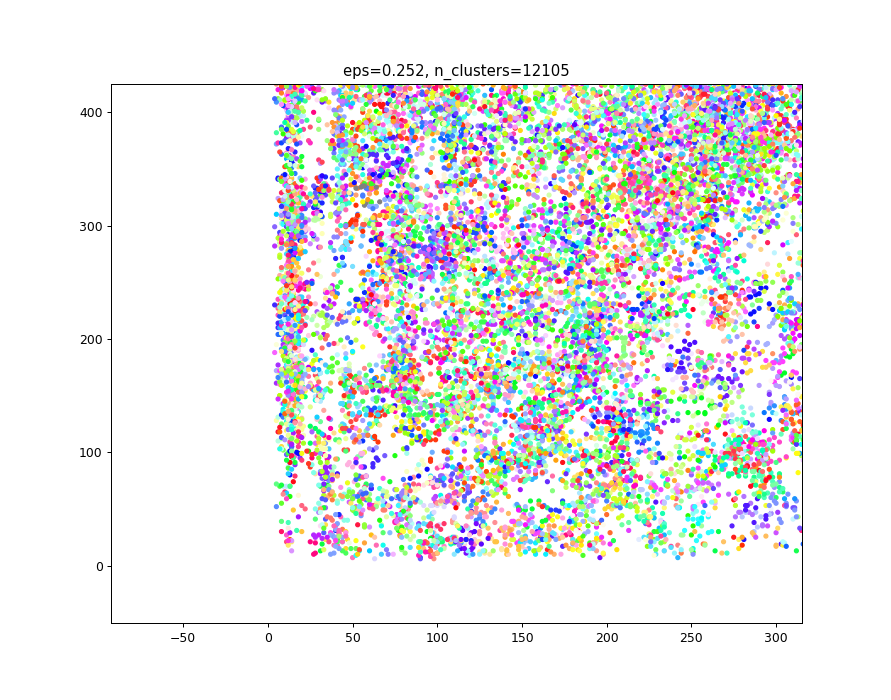

interactive(children=(IntSlider(value=1, description='t', max=20000), Output()), _dom_classes=('widget-interac…

In [47]:
%matplotlib notebook

display_clustering_widget(
    embeddings=meds, 
    min_samples=2, 
    max_samples=None,
    min_slider=0,
    max_slider=20000, 
    start_slider=1,
    single_color=False,
    )

In [49]:
sweep_t_vals = math_functions.bounded_logspace(0.1, 1.50, 50)

In [50]:
def _labels_to_idx(labels):
#     return {label: np.where(labels==label)[0] for label in np.unique(labels)}
    return [np.where(labels==label)[0] for label in np.unique(labels)]

def _labels_to_bool(labels):
#     return {label: np.where(labels==label)[0] for label in np.unique(labels)}
    return np.array([labels==label for label in np.unique(labels)])

def _freq_of_values(vals):
    u = np.unique(vals)
    f = np.array([np.sum(vals==unique) for unique in u])
    return np.array([f[u==val][0] for val in vals])




cluster_idx = []
for ii, t in tqdm(enumerate(sweep_t_vals)):
    [cluster_idx.append(scipy.sparse.csr_matrix(_labels_to_bool(scipy.cluster.hierarchy.fcluster(links[method], t=t, criterion='distance')))) for method in link_methods]
cluster_idx = scipy.sparse.vstack(cluster_idx)

0it [00:00, ?it/s]

In [51]:
def hash_matrix(x):
    y = np.array(np.packbits(x.todense(), axis=1))
    return np.array([hash(tuple(vec)) for vec in y])

In [52]:
# batch_size = 1000
# l = cluster_idx.shape[0]
# clusterHashes = np.concatenate([hash_matrix(batch) for batch in tqdm(indexing.make_batches(cluster_idx[:l], batch_size=batch_size, length=l), total=l/batch_size)], axis=0).shape

clusterHashes = np.concatenate(parallel_helpers.multiprocessing(hash_matrix, indexing.make_batches(cluster_idx, batch_size=100, length=cluster_idx.shape[0]), workers=32), axis=0)

In [53]:
# clusterHashes_block = [hash(tuple(vec)) for vec in cluster_idx]
# u, idx, c = np.unique(
#     ar=clusterHashes_block,
#     return_index=True,
#     return_counts=True,
# )

u, idx, c = np.unique(
    ar=clusterHashes,
    return_index=True,
    return_counts=True,
)

# clusters_idx_unique, clusters_idx_unique_freq = np.unique(cluster_idx, axis=0, return_counts=True)

clusters_idx_unique = cluster_idx[idx]
clusters_idx_unique_freq = c

In [54]:
min_samples = 2
max_samples = n_sessions

# sizes_clusters_raw = np.array([len(idx) for idx in clusters_idx_unique], dtype=np.int64)
sizes_clusters_raw = clusters_idx_unique.sum(1)
# print(clusters_idx_unique)

bool_tooSmall = (sizes_clusters_raw < min_samples).astype(np.bool8)
bool_tooBig = (sizes_clusters_raw > max_samples).astype(np.bool8)

idx_toDelete = np.array(bool_tooSmall + bool_tooBig).squeeze()

## remove clusters with too few samples
clusters_idx_unique = clusters_idx_unique[np.logical_not(idx_toDelete),:]
clusters_idx_unique_freq = clusters_idx_unique_freq[np.logical_not(idx_toDelete)]

# clusters_idx_unique = np.delete(clusters_idx_unique, idx_toDelete)
# clusters_idx_unique_freq = np.delete(clusters_idx_unique_freq, idx_toDelete)

In [179]:
h_raw = torch.stack([torch.as_tensor(indexing.idx2bool(idx.toarray().squeeze(), length=sim.n_roi), dtype=torch.float32) for idx in sim.cluster_idx], dim=0).T.type(torch.bool)

In [ ]:
h_raw = h_raw.to_sparse()

In [197]:
sim.h_raw = h_raw

In [185]:
h_raw

tensor(indices=tensor([[    0,     0,     0,  ..., 37060, 37060, 37060],
                       [ 1819,  2121,  3734,  ..., 29856, 30293, 35287]]),
       values=tensor([True, True, True,  ..., True, True, True]),
       size=(37061, 40411), nnz=247948, layout=torch.sparse_coo)

In [186]:
h_raw.shape

torch.Size([37061, 40411])

In [ ]:
sim._cluster_similarity_score(sim.s_conj, sim.h_raw)

In [194]:
h_raw.transpose(1,0)[10].shape
h_raw[10].shape

torch.Size([40411])

In [188]:
torch.sparse.sum(h_raw, dim=0)

tensor(indices=tensor([[    0,     1,     2,  ..., 40408, 40409, 40410]]),
       values=tensor([True, True, True,  ..., True, True, True]),
       size=(40411,), nnz=40411, layout=torch.sparse_coo)

In [ ]:
# c_score = clustering.cluster_similarity_score(s_conj**2, h_raw.type(torch.float32), method_in='mean', method_out='mean')
c_score = clustering.cluster_similarity_score(s_conj, h_raw, method_in='min', method_out='max')

In [ ]:
plt.figure()
plt.imshow(
#     c_score[:200, :200]*torch.logical_not(torch.eye(200)), 
    c_score[:1000, :1000], 
    aspect='auto',
    vmax=10
)

In [ ]:
c_sil = clustering.cluster_silhouette_score(s_conj, h_raw)

In [ ]:
# c_sil_norm = math_functions.generalised_logistic_function(torch.log(c_sil), mu=0.5)**1
c_sil_norm = c_sil

In [ ]:
c_redundant = ( (torch.einsum('ab, ac, bd -> cd', torch.eye(h_raw.shape[0], dtype=torch.float32), h_raw.type(torch.float32), h_raw.type(torch.float32))>0) * (torch.logical_not(torch.eye(h_raw.shape[1]))) ).type(torch.bool)

In [ ]:
w_raw = (((h_raw.cpu().sum(0) / n_sessions)**1) * (c_sil_norm.cpu()**1) * (clusters_idx_unique_freq / clusters_idx_unique_freq.max())**1)**1

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(w_raw.cpu())
# plt.ylim([0,1.1])
axs[1].plot(w_raw.cpu())
axs[1].set_yscale('log')

In [ ]:
idx_c_good = (w_raw>1e-6)
idx_c_good.sum() / w_raw.shape[0]

In [ ]:
DEVICE = 'cuda:0'

# c = (c_max*1 + c_mean*1)/2 + c_redundant*0
c = copy.copy(c_score)[idx_c_good][:,idx_c_good]

# c = c_max + c_redundant*1
# c = c_local*1
# c = c_sum
# c = c_mean
# c = c_local
# c = c_sum + c_redundant*2

h = copy.copy(h_raw)[:, idx_c_good]

w = w_raw[idx_c_good]

crc = clustering.Constrained_rich_clustering(
    c,
    h,
    w,
    device=DEVICE,
    m_init=(torch.ones(c.shape[0])*-5 + torch.rand(c.shape[0])*1).type(torch.float32),
    optimizer_partial=functools.partial(torch.optim.Adam, lr=1e-1, betas=(0.9, 0.900)),
    scheduler_partial=functools.partial(torch.optim.lr_scheduler.CyclicLR, base_lr=1e-4, max_lr=1e0, step_size_up=1000, cycle_momentum=False, verbose=False),
    dmCEL_temp=1,
    dmCEL_sigSlope=2,
    dmCEL_sigCenter=0.5,
    dmCEL_penalty=1e0,
    sampleWeight_softplusKwargs={'beta': 500, 'threshold': 50},
    sampleWeight_penalty=1e0,
    fracWeighted_goalFrac=1.0,
    fracWeighted_sigSlope=2,
    fracWeighted_sigCenter=0.5,
    fracWeight_penalty=1e-4,
    maskL1_penalty=0e-2,
    tol_convergence=1e-9,
    window_convergence=50,
    freqCheck_convergence=50,
    verbose=True,
)

In [ ]:
crc.fit(
    min_iter=1e3,
    max_iter=2e5,
    verbose=True, 
    verbose_interval=50
)

In [ ]:
crc.plot_loss()

In [ ]:
gc.collect()

torch.cuda.empty_cache()

gc.collect()

torch.cuda.empty_cache()

In [ ]:
crc.plot_clusterWeights()

In [ ]:
crc.plot_sampleWeights()

In [ ]:
crc.plot_clusterScores(bins=200)
plt.xscale('log')
plt.yscale('log')

In [ ]:
m_threshold=0.9

preds, confidence, scores_samples, m_bool = crc.predict(m_threshold=m_threshold)

In [ ]:
m_bool.sum()

In [ ]:
fig, axs = crc.plot_labelCounts()
axs[0].set_ylim([0,20])

In [ ]:
cmap = plotting_helpers.rand_cmap(nlabels=int(preds.max()), under=[0,0,0,0.0], verbose=False);
cmap

In [ ]:
colors = cmap(preds / preds.max())
colors[...,:3] *= confidence.numpy()[:,None]
# colors[...,:3] *= ((scores_samples / scores_samples.max()).numpy()**0.3)[:,None]

plt.figure()
plt.scatter(meds[:,0], meds[:,1], s=10, c=colors)

In [ ]:
plt.figure()
plt.hist(confidence);

In [ ]:
plt.figure()
plt.hist(confidence[preds>=0]);

# Colored clusters image
make an animation loop of an entire FOV looping through each session with all the ROIs. \
Each ROI in a cluster is given a distinct cluster color

In [ ]:
cmap = plotting_helpers.rand_cmap(nlabels=int(preds.max()), under=[0,0,0,0.0], verbose=False);
cmap

In [ ]:
idx_roi_cat = np.concatenate([np.arange(sfs.shape[0]) for sfs in ROIs_aligned]) # indices of each ROI concatenated together
idx_roi_session = np.concatenate([np.ones(sfs.shape[0])*ii for ii,sfs in enumerate(ROIs_aligned)])

In [ ]:
n_planes = n_sessions
labels = classification.squeeze_integers(preds.numpy().astype(np.int64))

labels[(confidence < 0.5).numpy()] = -1
# labels = labels

ucid_toUse = labels
idx_roi_session_toUse = idx_roi_session

colors = sparse.COO(rand_cmap(len(np.unique(ucid_toUse)), verbose=False)(np.int64(ucid_toUse))[:,:3])
# colors *= (1-((scores_samples / scores_samples.max()).numpy())**7)[:,None]
# colors *= (((1/scores_samples) / (1/scores_samples).max()).numpy()**1)[:,None]

plane_oneHot = classification.idx_to_oneHot(idx_roi_session_toUse.astype(np.int32))

ROIs_csr = scipy.sparse.csr_matrix(scipy.sparse.vstack(ROIs_aligned))
ROIs_csr_scaled = ROIs_csr.multiply(ROIs_csr.max(1).power(-1))
ROIs_sCOO = sparse.COO(ROIs_csr_scaled)

def tile_sparse(arr, n_tiles):
    """
    tiles along new (last) dimension
    """
    out = sparse.stack([arr for _ in range(n_tiles)], axis=-1)
    return out

ROIs_tiled = tile_sparse(tile_sparse(ROIs_sCOO, n_planes), 3)

ROIs_colored = ROIs_tiled * colors[:,None,None,:] * plane_oneHot[:,None,:,None]

FOV_ROIs_colored = ROIs_colored.sum(0).reshape((frame_height, frame_width, n_planes, 3)).transpose((2,0,1,3))

In [ ]:
FOV_all_noClip = copy.copy(FOV_ROIs_colored.todense())
FOV_all_noClip[FOV_all_noClip>1] = 1

In [ ]:
image_processing.play_video_cv2(FOV_all_noClip*255, frameRate=3, 
#                                 save_path='/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/run_20220403/run_liberal_4to9Sesh.avi'
                           )

In [ ]:
%matplotlib notebook
from ipywidgets import widgets, interact

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
imshow_FOV = ax.imshow(FOV_all_noClip[0], interpolation='none')

def update(i_frame = 0):
    fig.canvas.draw_idle()
    imshow_FOV.set_data(FOV_all_noClip[i_frame])


interact(update, i_frame=widgets.IntSlider(min=0, max=FOV_all_noClip.shape[0]-1, step=1, value=0));

In [ ]:
plt.figure()
plt.imshow(FOV_all_noClip.max(0))

outputs:
`UCIDs`
`UCIDs_bySession`

In [ ]:
## Only need to run this once since it is just pulling from stuff that should be static

ROIs_raw = scipy.sparse.vstack([scipy.sparse.csr_matrix(rois.reshape(rois.shape[0], -1)) for rois in tqdm(sf_all)])

ROIs = {
    "ROIs_aligned": ROIs_aligned,
    "ROIs_raw": ROIs_raw,
    "frame_height": frame_height,
    "frame_width": frame_width,
    "idx_roi_session": idx_roi_session
}

In [ ]:
name_save = os.path.split(dir_allOuterFolders)[-1]

In [ ]:
dir_save = Path(r'/media/rich/bigSSD/analysis_data/ROI_tracking/Valerio/4th_email/results/').resolve()

In [ ]:
def get_first_and_last_ROI_idx_from_each_session(ROIs_aligned):
    last_idx = np.cumsum([rois.shape[0] for rois in ROIs_aligned])
    first_idx = np.concatenate(([0], last_idx[:-1]))
    
    return list(first_idx), list(last_idx)

In [ ]:
preds_bySession = [list(preds[ii:jj].numpy().astype(np.int64)) for ii,jj in zip(get_first_and_last_ROI_idx_from_each_session(ROIs_aligned)[0], get_first_and_last_ROI_idx_from_each_session(ROIs_aligned)[1])]

In [ ]:
# pickle_helpers.simple_save(
#     {
#         "UCIDs": list(preds.numpy().astype(np.int64)),
#         "UCIDs_bySession": preds_bySession,
#         "ROIs": ROIs,
#     },
#     filename=dir_save / (name_save + '.plane0.rClust' '.pkl'),
# #     filename='/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/UCIDs.pkl'
# )